# 数据科学大作业

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

from sklearn.model_selection import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import random
import pickle
import time

np.random.seed(666)
random_seed = 666

d:\1\anaconda3\envs\labelme2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. 读取数据 & 数据清理

### 1.1 数据读取

In [2]:
df = pd.read_csv('adult.txt')
df.columns = [
    "age", "work_class", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]
print(df.sample(5, random_state=666))

       age work_class  fnlwgt      education  education_num  marital_status  \
37391   36    Private  228652   Some-college             10        Divorced   
23684   24    Private  249046      Bachelors             13   Never-married   
47602   55    Private  173832        Masters             14        Divorced   
3192    71    Private  157909   Some-college             10   Never-married   
22276   39    Private   98776   Some-college             10        Divorced   

               occupation    relationship    race      sex  capital_gain  \
37391   Machine-op-inspct       Own-child   Other     Male             0   
23684        Tech-support       Own-child   White     Male             0   
47602               Sales   Not-in-family   White     Male         10520   
3192        Other-service   Not-in-family   White   Female          2964   
22276     Exec-managerial   Not-in-family   White     Male             0   

       capital_loss  hours_per_week  native_country   income  
37391

### 1.2 数据清理

In [3]:
with open('adult.txt', 'r') as f:
    raw_data = f.readlines()[1:]
    data = []

    for line in raw_data:
        line = line.strip().rstrip(',')
        data.append(line.split(', '))

#print(random.sample(data, 100))
miss = [0] * 5
del_list = []
for i, d in enumerate(data):
    nan = d.count('?')
    if nan > 0:
        del_list.append(i)
        miss[nan] += 1

print(miss)
print(len(del_list))

[0, 821, 2753, 46, 0]
3620


In [6]:
real_data = []
for i, d in enumerate(data):
    if not i in del_list:
        real_data.append(d)
    
print(len(real_data))
with open('real_data.pkl', 'wb') as f:
    pickle.dump(real_data, f)
# for i, d in enumerate(real_data):
#     nan = d.count('?')
#     if nan > 0:
#         print(d)

45222


## 2. 探索各特征的分布

In [2]:
with open('real_data.pkl', 'rb') as f:
    real_data = pickle.load(f)
real_df = pd.DataFrame(real_data)
class_list = [
    "age", "work_class", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]
real_df.columns = class_list

num_feature = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
class_feature = ["work_class", "education", "marital_status", "occupation", "relationship", "race", "sex",
    "native_country", "income"
]

### 2.1 数值特征的数值特征

In [3]:
num_real_df = pd.DataFrame(real_df[num_feature], dtype=np.int32)
num_real_df.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,45222.000000,4.522200e+04,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,1.897347e+05,10.118460,1101.430344,88.595418,40.938017
std,13.217870,1.056392e+05,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.173882e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783160e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.379260e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


### 2.2 数值特征的分布图

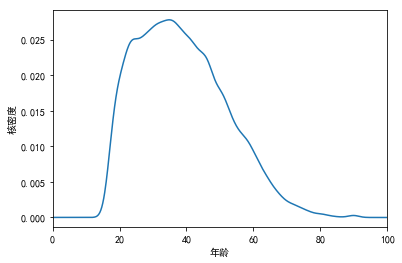

In [4]:
tar_df = num_real_df['age']
plt.figure(figsize=(6, 4))
tar_df.plot(kind='kde')

plt.xlabel(u'年龄')
plt.ylabel(u'核密度')
plt.xlim((0, 100))
plt.savefig('report/img/age_dis.pdf')
plt.show()

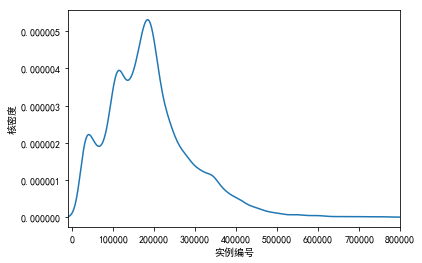

In [16]:
tar_df = num_real_df['fnlwgt']
plt.figure(figsize=(6, 4))
tar_df.plot(kind='kde')

plt.xlabel(u'实例编号')
plt.ylabel(u'核密度')
plt.xlim((-10000, 800000))
plt.subplots_adjust(left=0.16, right=0.93)
plt.savefig('report/img/fnlwgt_dis.pdf')
plt.show()

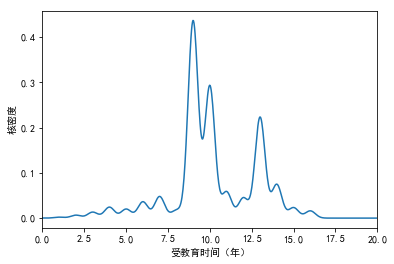

In [6]:
tar_df = num_real_df['education_num']
plt.figure(figsize=(6, 4))
tar_df.plot(kind='kde')

plt.xlabel(u'受教育时间（年）')
plt.ylabel(u'核密度')
plt.xlim((0, 20))
plt.savefig('report/img/edu_num_dis.pdf')
plt.show()

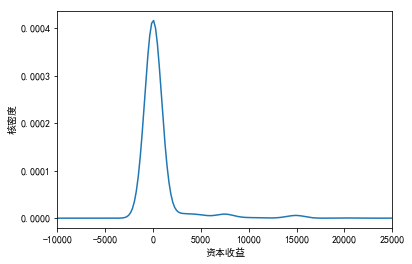

In [7]:
tar_df = num_real_df['capital_gain']
plt.figure(figsize=(6, 4))
tar_df.plot(kind='kde')

plt.xlabel(u'资本收益')
plt.ylabel(u'核密度')
plt.xlim((-10000, 25000))
plt.savefig('report/img/cap_in_dis.pdf')
plt.show()

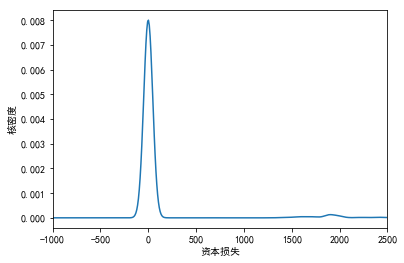

In [8]:
tar_df = num_real_df['capital_loss']
plt.figure(figsize=(6, 4))
tar_df.plot(kind='kde')

plt.xlabel(u'资本损失')
plt.ylabel(u'核密度')
plt.xlim((-1000, 2500))
plt.savefig('report/img/cap_out_dis.pdf')
plt.show()

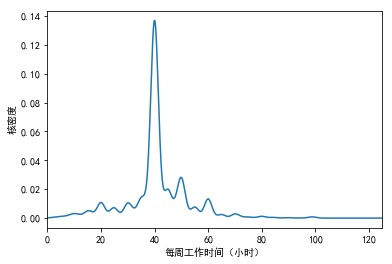

In [19]:
tar_df = num_real_df['hours_per_week']
plt.figure(figsize=(6, 4))
tar_df.plot(kind='kde')

plt.xlabel(u'每周工作时间（小时）')
plt.ylabel(u'核密度')
plt.xlim((0, 125))
plt.savefig('report/img/hours_per_week_dis.pdf')
plt.show()

### 2.3 类别数据的分布

In [4]:
class_real_df = real_df[class_feature]
class_real_df.describe()

,work_class,education,marital_status,occupation,relationship,race,sex,native_country,income
count,45222,45222,45222,45222,45222,45222,45222,45222,45222
unique,7,16,7,14,6,5,2,41,4
top,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K
freq,33307,14783,21055,6020,18666,38903,30527,41292,22654


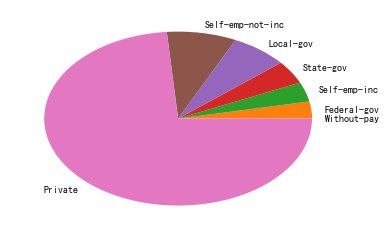

In [10]:
tar_df = class_real_df['work_class']
plt.figure(figsize=(6, 4))
tar_df.value_counts(ascending=True).plot(kind='pie', label='')

plt.savefig('report/img/work_class_dis.pdf')
plt.show()

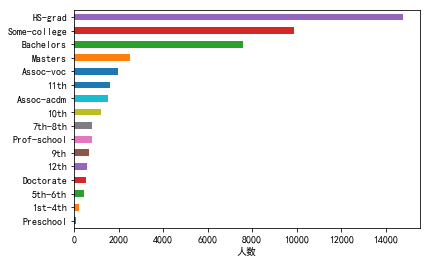

In [13]:
tar_df = class_real_df['education']
plt.figure(figsize=(6, 4))
tar_df.value_counts(ascending=True).plot(kind='barh')

plt.xlabel(u'人数')
plt.subplots_adjust(left=0.17, right=0.97)
plt.savefig('report/img/edu_dis.pdf')
plt.show()

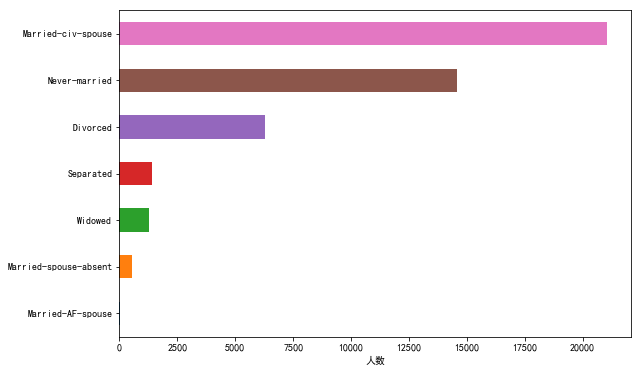

In [30]:
tar_df = class_real_df['marital_status']
plt.figure(figsize=(9, 6))
tar_df.value_counts(ascending=True).plot(kind='barh')

plt.xlabel(u'人数')
plt.subplots_adjust(left=0.18, right=0.97)
plt.savefig('report/img/marry_dis.pdf')
plt.show()

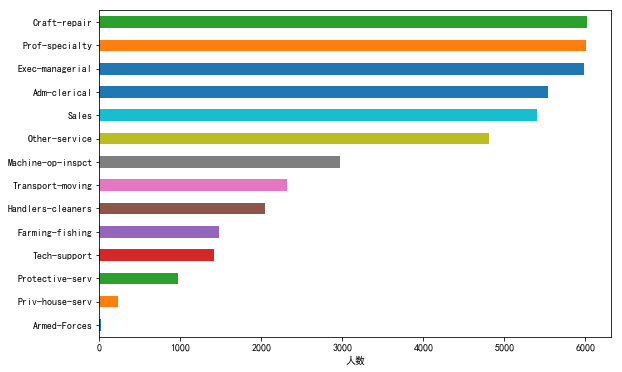

In [26]:
tar_df = class_real_df['occupation']
plt.figure(figsize=(9, 6))
tar_df.value_counts(ascending=True).plot(kind='barh')

plt.xlabel(u'人数')
plt.subplots_adjust(left=0.18, right=0.97)
plt.savefig('report/img/occupation_dis.pdf')
plt.show()

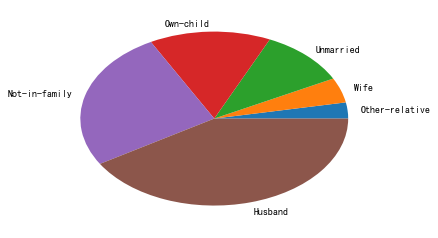

In [14]:
tar_df = class_real_df['relationship']
plt.figure(figsize=(6, 4))
tar_df.value_counts(ascending=True).plot(kind='pie', label='')

plt.savefig('report/img/relationship_dis.pdf')
plt.show()

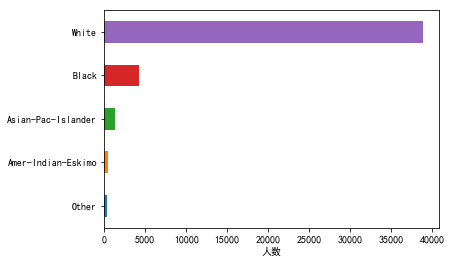

In [15]:
tar_df = class_real_df['race']
plt.figure(figsize=(6, 4))
tar_df.value_counts(ascending=True).plot(kind='barh')

plt.xlabel(u'人数')
plt.savefig('report/img/race_dis.pdf')
plt.show()

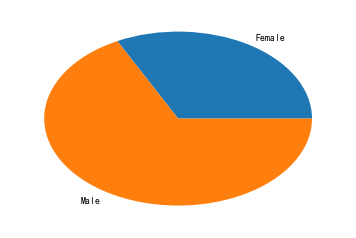

In [16]:
tar_df = class_real_df['sex']
plt.figure(figsize=(6, 4))
tar_df.value_counts(ascending=True).plot(kind='pie', label='')

plt.savefig('report/img/sex_dis.pdf')
plt.show()

['United-States', 'Cuba', 'Jamaica', 'India', 'Mexico', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany', 'Iran', 'Philippines', 'Poland', 'Columbia', 'Cambodia', 'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal', 'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala', 'Italy', 'China', 'South', 'Japan', 'Yugoslavia', 'Peru', 'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago', 'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary', 'Holand-Netherlands']


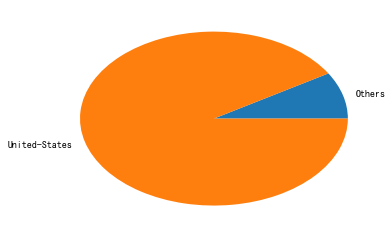

In [21]:
tar_df = class_real_df['native_country']
all_country = list(class_real_df['native_country'].unique())
print(all_country)
all_country.remove('United-States')

tar_df2 = tar_df
for country in all_country:
    tar_df2 = tar_df2.replace(country, 'Others')
tar_df2

#plt.figure(figsize=(10, 15))
plt.figure(figsize=(6, 4))
tar_df2.value_counts(ascending=True).plot(kind='pie', label='')

plt.savefig('report/img/native_country_dis.pdf')
plt.show()

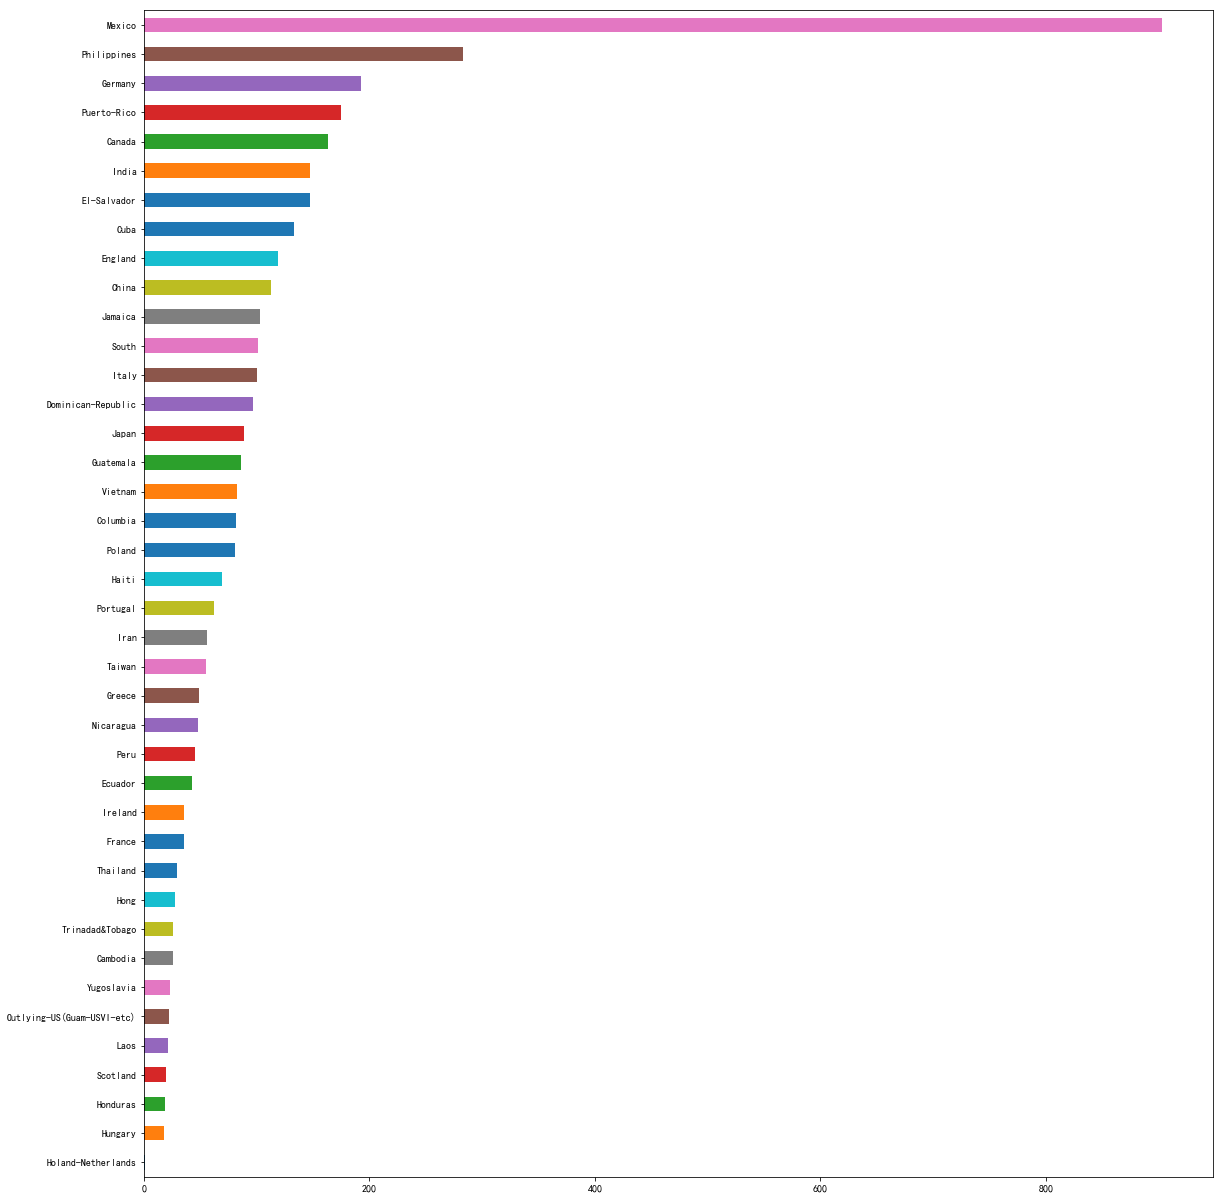

In [18]:
tar_df = class_real_df[class_real_df['native_country'] != 'United-States']['native_country']

plt.figure(figsize=(18, 18))
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.125, right=0.95)
tar_df.value_counts(ascending=True).plot(kind='barh')

plt.savefig('report/img/native_country_dis2.pdf')
plt.show()

# 3. 计算各特征的相关性

# 4. 数据预处理

## 4.1 向量化

In [46]:
# read data
with open('real_data.pkl', 'rb') as f:
    real_data = pickle.load(f)
real_df = pd.DataFrame(real_data)

class_list = [
    "age", "work_class", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]
real_df.columns = class_list
target = real_df['income'].map({ "<=50K": -1, "<=50K.": -1, ">50K": 1, ">50K.": -1 })
print(pd.value_counts(real_df['income']))
real_df = real_df.drop('income', axis=1)

# save the target as .npy
print(target.values.shape)
np.save('adult_y.npy', target.values)

num_feature = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
class_feature = ["work_class", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]

# vectorize and save the features as .npy
vec_df = pd.DataFrame(pd.get_dummies(real_df, columns=class_feature), dtype=np.int32)
np.save('adult_x.npy', vec_df.values)

<=50K     22654
<=50K.    11360
>50K       7508
>50K.      3700
Name: income, dtype: int64
(45222,)


# 5. 分类

In [2]:
def norm(data):
    scaler = StandardScaler()
    scaler.fit(data)
    return scaler.transform(data)

# load data
X = np.load('adult_x.npy')
Y = np.load('adult_y.npy')

# 5.1 baseline

In [13]:
def DT(x, y, x_t, y_t):
    model = DecisionTreeClassifier(random_state=random_seed)
    model.fit(x, y)
    y_pre = model.predict(x_t)
    print(classification_report(y_t, y_pre))
    return precision_score(y_t, y_pre, average='micro'), accuracy_score(y_t, y_pre), f1_score(y_t, y_pre, average='micro')
    
def SVM(x, y, x_t, y_t):
    model = SVC(random_state=random_seed)
    model.fit(x, y)
    y_pre = model.predict(x_t)
    print(classification_report(y_t, y_pre))
    return precision_score(y_t, y_pre, average='micro'), accuracy_score(y_t, y_pre), f1_score(y_t, y_pre, average='micro')
    
def MLP(x, y, x_t, y_t):
    model = MLPClassifier(random_state=random_seed)
    model.fit(x, y)
    y_pre = model.predict(x_t)
    print(classification_report(y_t, y_pre))
    return precision_score(y_t, y_pre, average='micro'), accuracy_score(y_t, y_pre), f1_score(y_t, y_pre, average='micro')
    
def NULL(x, y, x_t, y_t):
    y_pre = np.random.random(y_t.shape)
    y_pre[np.where(y_pre>0.5)] = 1
    y_pre[np.where(y_pre<=0.5)] = -1
    print(classification_report(y_t, y_pre))
    return precision_score(y_t, y_pre, average='micro'), accuracy_score(y_t, y_pre), f1_score(y_t, y_pre, average='micro')

In [ ]:
# split dataset 0.8-0.2
x, x_t, y, y_t = train_test_split(X, Y, test_size=0.2, random_state=random_seed)

t = time.time()
DT(x, y, x_t, y_t)
print('used time: ', time.time() - t)

In [ ]:
# 5-fold cv
skfolds = StratifiedKFold(Y, n_folds=5)

pre, acc, f1 = [], [], []
t = time.time()
for train,test in skfolds:
    x, y, x_t, y_t = X[train], Y[train], X[test], Y[test]
    p, a, f = SVM(x, y, x_t, y_t)
    pre.append(p)
    acc.append(a)
    f1.append(f)

print('used time: ', time.time() - t)
print('avg precision: ', np.array(pre).mean())
print('avg accuracy: ', np.array(acc).mean())
print('avg f1-score: ', np.array(f1).mean())

             precision    recall  f1-score   support

         -1       0.84      0.99      0.91      7543
          1       0.34      0.02      0.05      1502

avg / total       0.75      0.83      0.76      9045

             precision    recall  f1-score   support

         -1       0.84      0.99      0.91      7543
          1       0.42      0.03      0.06      1502

avg / total       0.77      0.83      0.77      9045

